# Day 66 - Introduction to Transfer Learning

## Introduction

Transfer learning is one of the most powerful techniques in modern machine learning. Instead of training a model from scratch, transfer learning leverages knowledge gained from solving one problem and applies it to a different but related problem. This approach has revolutionized how we build machine learning models, especially when dealing with limited data or computational resources.

Imagine you're learning to play the piano after already mastering the guitar. You don't start from zero—you transfer your understanding of rhythm, music theory, and finger coordination. Similarly, in machine learning, a model trained on a large dataset can learn useful features that transfer well to new, related tasks, even with limited training data.

Transfer learning matters because training complex models from scratch requires enormous amounts of data, significant computational power, and extensive expertise. By using pre-trained representations, we can achieve excellent results with much less data, shorter training times, and reduced computational costs.

### Learning Objectives

By the end of this lesson, you will be able to:

- Understand the fundamental concepts of transfer learning and why it's effective
- Distinguish between feature extraction and fine-tuning approaches
- Implement transfer learning using sklearn's feature extraction techniques
- Demonstrate the data efficiency and performance benefits of transfer learning
- Compare models built with transfer learning versus training from scratch

## Theory: Understanding Transfer Learning

### What is Transfer Learning?

Transfer learning is a machine learning method where a model developed for one task is reused as the starting point for a model on a second task. Formally, given a source domain $D_S$ with task $T_S$, and a target domain $D_T$ with task $T_T$, transfer learning aims to improve the learning of the target predictive function $f_T(\cdot)$ in $D_T$ using the knowledge in $D_S$ and $T_S$, where $D_S \neq D_T$ or $T_S \neq T_T$.

### Mathematical Foundation

In supervised learning, we typically learn a function:

$$f: X \rightarrow Y$$

where $X$ is the input space and $Y$ is the output space. In transfer learning, we decompose this into:

$$f(x) = g(\phi(x))$$

where:
- $\phi: X \rightarrow Z$ is a feature extractor mapping inputs to a learned representation space $Z$
- $g: Z \rightarrow Y$ is a task-specific classifier

### Types of Transfer Learning

#### 1. Feature Extraction

In feature extraction, we use a pre-trained feature extractor $\phi_{pre}$ (learned on source task) and freeze it:

$$y = g(\phi_{pre}(x); \theta_{new})$$

We optimize only $\theta_{new}$ (the new classifier weights) while keeping $\phi_{pre}$ fixed.

**Advantages:**
- Fast training (fewer parameters to optimize)
- Works well with small target datasets
- Prevents overfitting when data is limited

#### 2. Fine-Tuning

Fine-tuning allows the pre-trained features to adapt:

$$\min_{\theta_{feat}', \theta_{new}} \mathcal{L}(y, g(\phi(x; \theta_{feat}'); \theta_{new}))$$

where $\theta_{feat}'$ starts from pre-trained values and is updated with a small learning rate.

### Why Does Transfer Learning Work?

The key insight is that learned representations often contain hierarchical features:
- **Low-level features**: Edges, corners, simple patterns (highly transferable)
- **Mid-level features**: Shapes, textures, object parts (moderately transferable)
- **High-level features**: Task-specific patterns (less transferable)

### Domain Adaptation

Transfer learning often involves domain adaptation. Let $P_S(X, Y)$ be the joint distribution in the source domain, and $P_T(X, Y)$ in the target domain. We assume:

$$P_S(Y|X) \approx P_T(Y|X)$$

This means the relationship between features and labels is similar across domains, even if feature distributions differ ($P_S(X) \neq P_T(X)$).

### Transfer Loss

The total loss when using transfer learning can be decomposed as:

$$\mathcal{L}_{total} = \mathcal{L}_{task} + \lambda \mathcal{L}_{transfer}$$

where:
- $\mathcal{L}_{task}$ is the task-specific loss (e.g., cross-entropy)
- $\mathcal{L}_{transfer}$ regularizes to keep weights close to pre-trained values
- $\lambda$ controls the regularization strength

## Python Implementation: Transfer Learning with Sklearn

We'll demonstrate transfer learning using sklearn's digits dataset. Our approach:
1. Create a **source task**: classify all 10 digits (0-9)
2. Learn a feature extractor (PCA) on the source task
3. Create a **target task**: classify a subset of digits with limited data
4. Compare performance with and without transfer learning

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4


### Step 1: Load and Explore the Dataset

We'll use the sklearn digits dataset, which contains 1797 8x8 grayscale images of handwritten digits.

Dataset shape: (1797, 64)
Number of samples: 1797
Number of features: 64
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


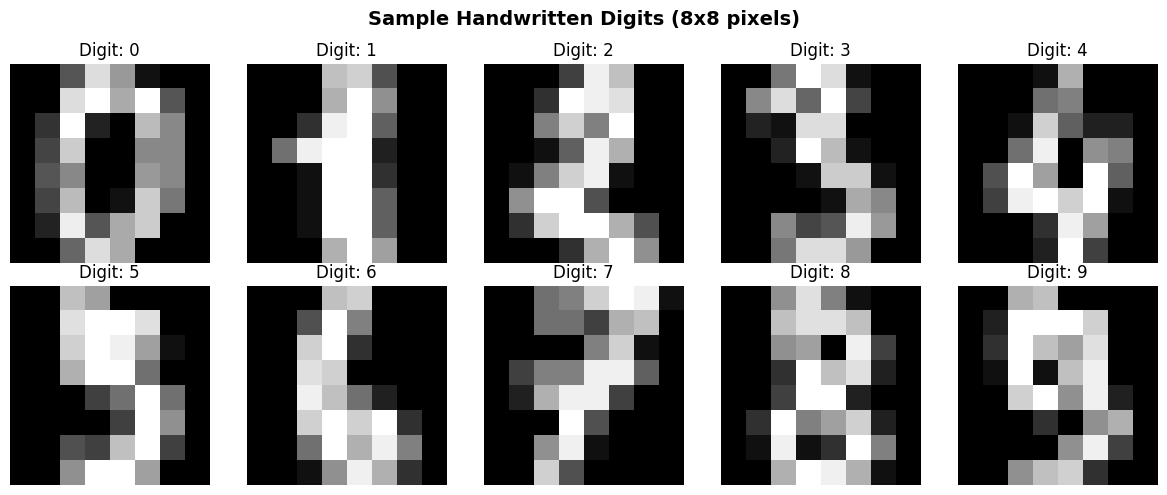

In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")

# Visualize sample digits
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f'Digit: {digits.target[i]}')
    axes[i].axis('off')

plt.suptitle('Sample Handwritten Digits (8x8 pixels)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Step 2: Prepare Source and Target Tasks

**Source Task**: Classify all 10 digits (0-9) with plenty of data

**Target Task**: Classify only digits 0-4 with limited data

This simulates a real-world scenario where we have abundant data for a general task but limited data for a specific task.

SOURCE TASK (All 10 digits):
Training samples: 1437
Test samples: 360
Classes: [0 1 2 3 4 5 6 7 8 9]

TARGET TASK (Digits 0-4 only, limited data):
Training samples: 105
Validation samples: 45
Test samples: 751
Classes: [0 1 2 3 4]


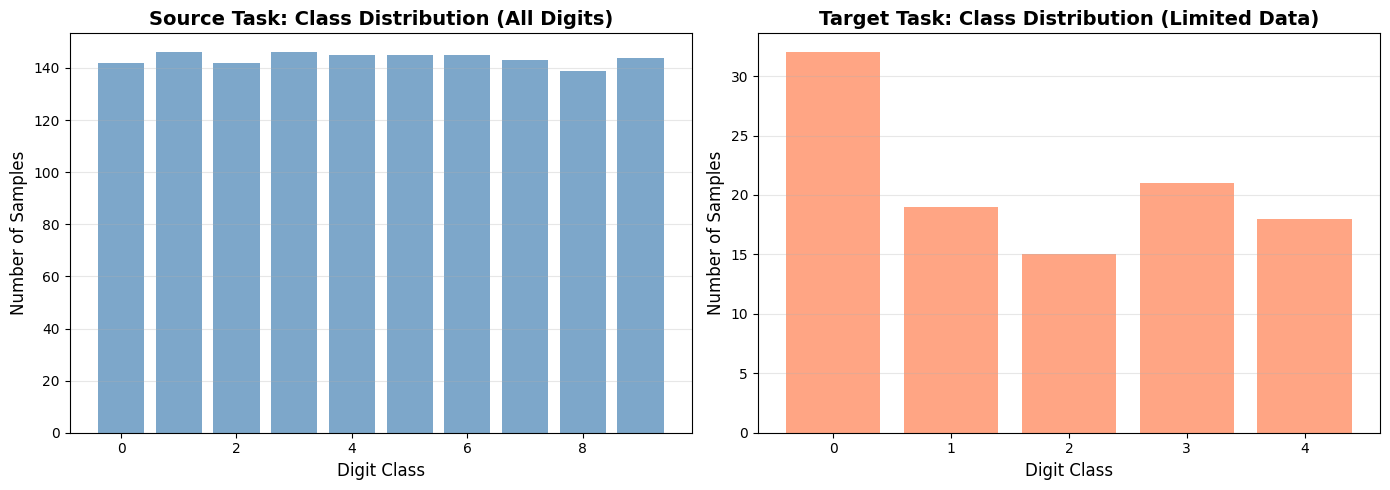

In [3]:
# Prepare SOURCE task data (all digits, full dataset)
X_source = X.copy()
y_source = y.copy()

# Split source data
X_source_train, X_source_test, y_source_train, y_source_test = train_test_split(
    X_source, y_source, test_size=0.2, random_state=42, stratify=y_source
)

print("SOURCE TASK (All 10 digits):")
print(f"Training samples: {X_source_train.shape[0]}")
print(f"Test samples: {X_source_test.shape[0]}")
print(f"Classes: {np.unique(y_source)}")

# Prepare TARGET task data (only digits 0-4, limited samples)
# Select only digits 0-4
target_mask = y <= 4
X_target_full = X[target_mask]
y_target_full = y[target_mask]

# Simulate limited data by using only a small portion
n_target_samples = 150  # Very limited data
indices = np.random.choice(len(X_target_full), n_target_samples, replace=False)
X_target_limited = X_target_full[indices]
y_target_limited = y_target_full[indices]

# Split target data (use remaining data as test set)
remaining_mask = np.ones(len(X_target_full), dtype=bool)
remaining_mask[indices] = False
X_target_test = X_target_full[remaining_mask]
y_target_test = y_target_full[remaining_mask]

# Further split limited data into train/val
X_target_train, X_target_val, y_target_train, y_target_val = train_test_split(
    X_target_limited, y_target_limited, test_size=0.3, random_state=42, stratify=y_target_limited
)

print("\nTARGET TASK (Digits 0-4 only, limited data):")
print(f"Training samples: {X_target_train.shape[0]}")
print(f"Validation samples: {X_target_val.shape[0]}")
print(f"Test samples: {X_target_test.shape[0]}")
print(f"Classes: {np.unique(y_target_train)}")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

unique, counts = np.unique(y_source_train, return_counts=True)
ax1.bar(unique, counts, color='steelblue', alpha=0.7)
ax1.set_xlabel('Digit Class', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Source Task: Class Distribution (All Digits)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

unique, counts = np.unique(y_target_train, return_counts=True)
ax2.bar(unique, counts, color='coral', alpha=0.7)
ax2.set_xlabel('Digit Class', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_title('Target Task: Class Distribution (Limited Data)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Step 3: Train Source Model and Extract Features

We'll train a feature extractor (PCA) on the source task. PCA learns a linear transformation that captures the most important patterns in the data.

Original feature dimension: 64
Reduced feature dimension: 30
Variance explained by 30 components: 0.8933

Source Task Accuracy: 0.9556


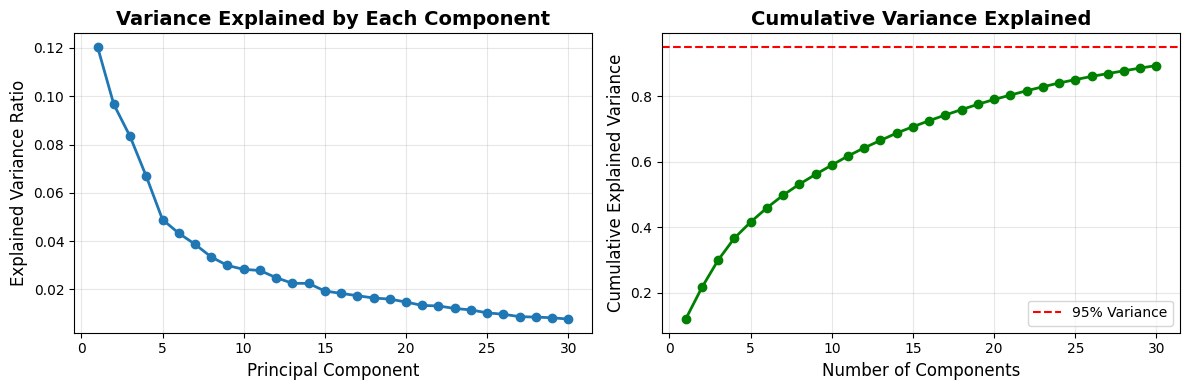

In [4]:
# Create and train feature extractor on source task
scaler_source = StandardScaler()
X_source_train_scaled = scaler_source.fit_transform(X_source_train)
X_source_test_scaled = scaler_source.transform(X_source_test)

# Train PCA as our "pre-trained" feature extractor
n_components = 30  # Reduced dimensionality
pca_pretrained = PCA(n_components=n_components, random_state=42)
X_source_train_pca = pca_pretrained.fit_transform(X_source_train_scaled)
X_source_test_pca = pca_pretrained.transform(X_source_test_scaled)

print(f"Original feature dimension: {X_source_train.shape[1]}")
print(f"Reduced feature dimension: {X_source_train_pca.shape[1]}")
print(f"Variance explained by {n_components} components: {pca_pretrained.explained_variance_ratio_.sum():.4f}")

# Train classifier on source task
clf_source = LogisticRegression(max_iter=1000, random_state=42)
clf_source.fit(X_source_train_pca, y_source_train)

# Evaluate source task performance
y_source_pred = clf_source.predict(X_source_test_pca)
source_accuracy = accuracy_score(y_source_test, y_source_pred)

print(f"\nSource Task Accuracy: {source_accuracy:.4f}")

# Visualize explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_components + 1), pca_pretrained.explained_variance_ratio_, 
         marker='o', linestyle='-', linewidth=2)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Variance Explained by Each Component', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumsum = np.cumsum(pca_pretrained.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), cumsum, marker='o', linestyle='-', linewidth=2, color='green')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4: Visualize Learned Features

Let's visualize the first few principal components learned by our feature extractor.

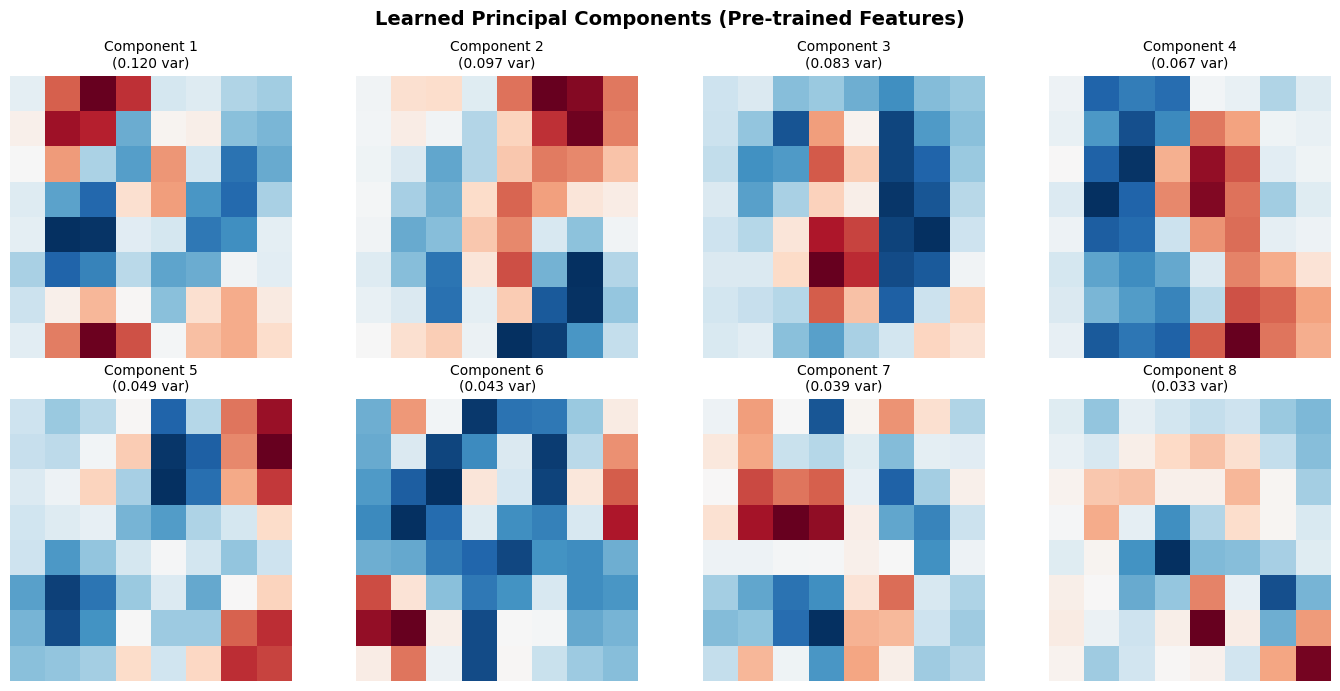

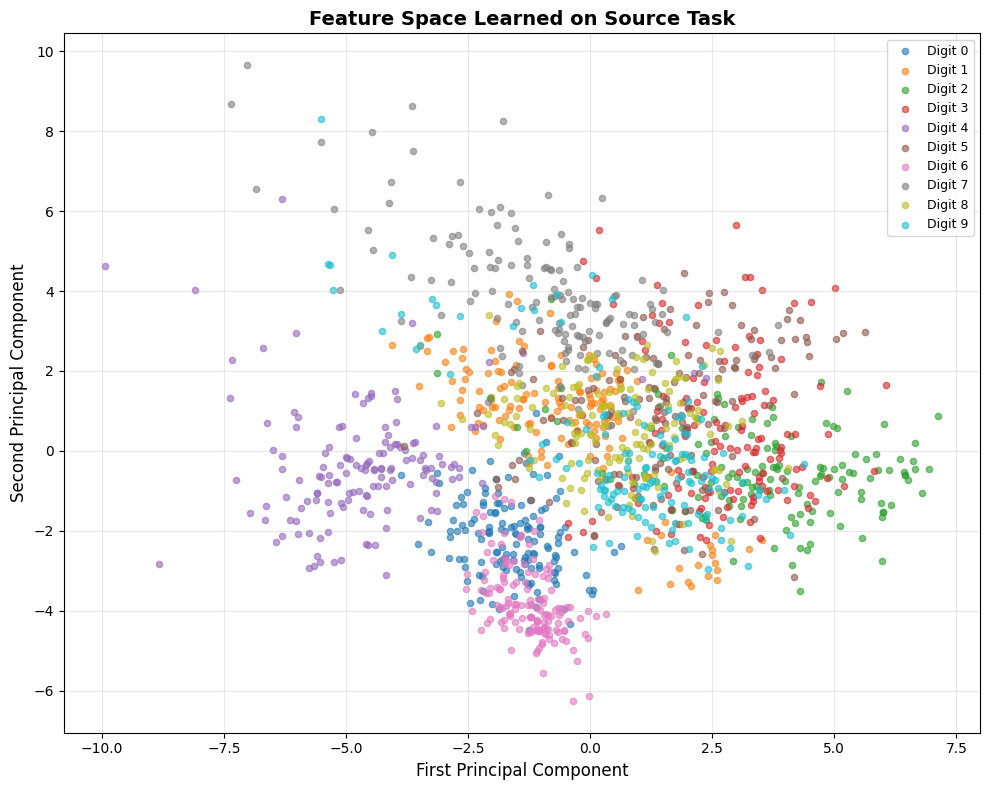

In [5]:
# Visualize first 8 principal components
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.ravel()

for i in range(8):
    component = pca_pretrained.components_[i].reshape(8, 8)
    axes[i].imshow(component, cmap='RdBu_r')
    axes[i].set_title(f'Component {i+1}\n({pca_pretrained.explained_variance_ratio_[i]:.3f} var)', 
                      fontsize=10)
    axes[i].axis('off')

plt.suptitle('Learned Principal Components (Pre-trained Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualize feature space (first 2 components)
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for digit in range(10):
    mask = y_source_train == digit
    plt.scatter(X_source_train_pca[mask, 0], X_source_train_pca[mask, 1], 
               c=[colors[digit]], label=f'Digit {digit}', alpha=0.6, s=20)

plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('Feature Space Learned on Source Task', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Apply Transfer Learning to Target Task

Now we'll use the pre-trained feature extractor on our target task with limited data.

In [6]:
# Method 1: TRANSFER LEARNING - Use pre-trained PCA features
print("=" * 60)
print("METHOD 1: TRANSFER LEARNING (Using Pre-trained Features)")
print("=" * 60)

# Scale using source task's scaler (important for transfer learning)
X_target_train_scaled = scaler_source.transform(X_target_train)
X_target_val_scaled = scaler_source.transform(X_target_val)
X_target_test_scaled = scaler_source.transform(X_target_test)

# Transform using pre-trained PCA (frozen, not retrained)
X_target_train_transfer = pca_pretrained.transform(X_target_train_scaled)
X_target_val_transfer = pca_pretrained.transform(X_target_val_scaled)
X_target_test_transfer = pca_pretrained.transform(X_target_test_scaled)

print(f"Training on {X_target_train_transfer.shape[0]} samples with {X_target_train_transfer.shape[1]} features")

# Train new classifier on pre-trained features
clf_transfer = LogisticRegression(max_iter=1000, random_state=42)
clf_transfer.fit(X_target_train_transfer, y_target_train)

# Evaluate
y_val_pred_transfer = clf_transfer.predict(X_target_val_transfer)
y_test_pred_transfer = clf_transfer.predict(X_target_test_transfer)

val_acc_transfer = accuracy_score(y_target_val, y_val_pred_transfer)
test_acc_transfer = accuracy_score(y_target_test, y_test_pred_transfer)

print(f"Validation Accuracy: {val_acc_transfer:.4f}")
print(f"Test Accuracy: {test_acc_transfer:.4f}")

# Method 2: TRAINING FROM SCRATCH - Learn PCA from target data
print("\n" + "=" * 60)
print("METHOD 2: TRAINING FROM SCRATCH (No Transfer)")
print("=" * 60)

# Scale target data independently
scaler_target = StandardScaler()
X_target_train_scaled_scratch = scaler_target.fit_transform(X_target_train)
X_target_val_scaled_scratch = scaler_target.transform(X_target_val)
X_target_test_scaled_scratch = scaler_target.transform(X_target_test)

# Train new PCA from scratch on limited target data
pca_scratch = PCA(n_components=n_components, random_state=42)
X_target_train_scratch = pca_scratch.fit_transform(X_target_train_scaled_scratch)
X_target_val_scratch = pca_scratch.transform(X_target_val_scaled_scratch)
X_target_test_scratch = pca_scratch.transform(X_target_test_scaled_scratch)

print(f"Training on {X_target_train_scratch.shape[0]} samples with {X_target_train_scratch.shape[1]} features")
print(f"Variance explained: {pca_scratch.explained_variance_ratio_.sum():.4f}")

# Train classifier from scratch
clf_scratch = LogisticRegression(max_iter=1000, random_state=42)
clf_scratch.fit(X_target_train_scratch, y_target_train)

# Evaluate
y_val_pred_scratch = clf_scratch.predict(X_target_val_scratch)
y_test_pred_scratch = clf_scratch.predict(X_target_test_scratch)

val_acc_scratch = accuracy_score(y_target_val, y_val_pred_scratch)
test_acc_scratch = accuracy_score(y_target_test, y_test_pred_scratch)

print(f"Validation Accuracy: {val_acc_scratch:.4f}")
print(f"Test Accuracy: {test_acc_scratch:.4f}")

# Compare results
print("\n" + "=" * 60)
print("COMPARISON")
print("=" * 60)
print(f"Transfer Learning Test Accuracy: {test_acc_transfer:.4f}")
print(f"From Scratch Test Accuracy: {test_acc_scratch:.4f}")
print(f"Improvement: {(test_acc_transfer - test_acc_scratch):.4f} ({100*(test_acc_transfer - test_acc_scratch)/test_acc_scratch:.2f}%)")

METHOD 1: TRANSFER LEARNING (Using Pre-trained Features)
Training on 105 samples with 30 features
Validation Accuracy: 0.9778
Test Accuracy: 0.9521

METHOD 2: TRAINING FROM SCRATCH (No Transfer)
Training on 105 samples with 30 features
Variance explained: 0.9654
Validation Accuracy: 0.9778
Test Accuracy: 0.9507

COMPARISON
Transfer Learning Test Accuracy: 0.9521
From Scratch Test Accuracy: 0.9507
Improvement: 0.0013 (0.14%)


### Step 6: Visualize Performance Comparison

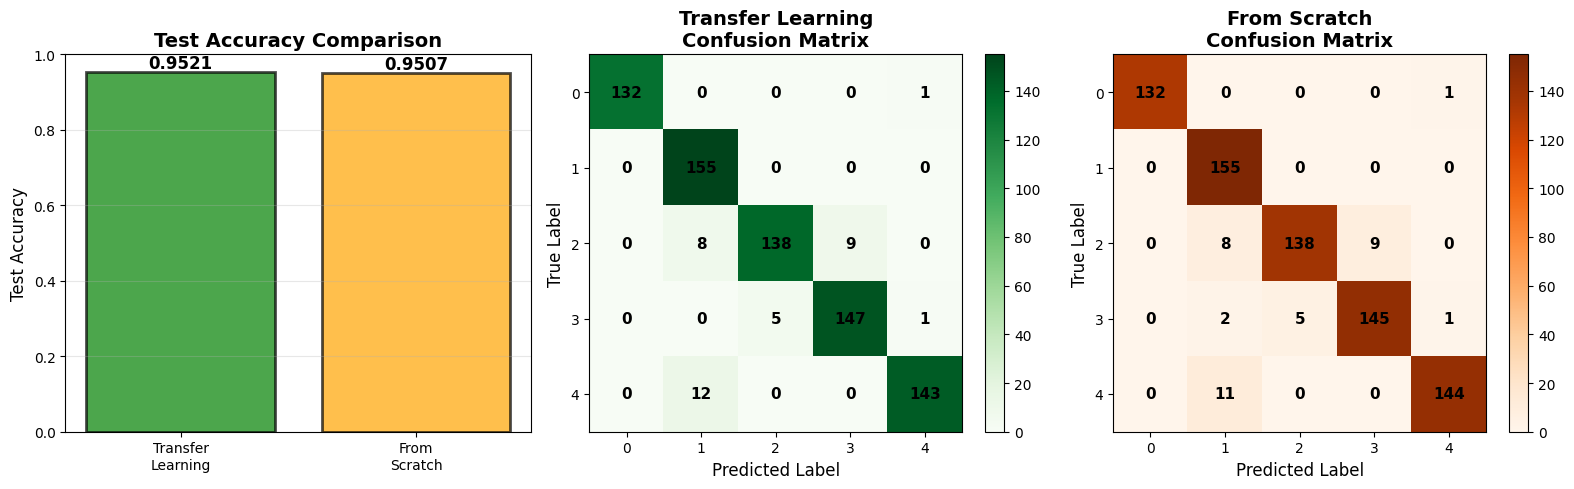

In [7]:
# Create comparison visualizations
fig = plt.figure(figsize=(16, 5))

# 1. Accuracy comparison bar chart
ax1 = plt.subplot(1, 3, 1)
methods = ['Transfer\nLearning', 'From\nScratch']
accuracies = [test_acc_transfer, test_acc_scratch]
colors_bar = ['green', 'orange']
bars = ax1.bar(methods, accuracies, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)

# 2. Confusion Matrix for Transfer Learning
ax2 = plt.subplot(1, 3, 2)
cm_transfer = confusion_matrix(y_target_test, y_test_pred_transfer)
im2 = ax2.imshow(cm_transfer, cmap='Greens', aspect='auto')
ax2.set_xticks(range(5))
ax2.set_yticks(range(5))
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title('Transfer Learning\nConfusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(5):
    for j in range(5):
        text = ax2.text(j, i, cm_transfer[i, j],
                       ha="center", va="center", color="black", fontsize=11, fontweight='bold')
plt.colorbar(im2, ax=ax2)

# 3. Confusion Matrix for From Scratch
ax3 = plt.subplot(1, 3, 3)
cm_scratch = confusion_matrix(y_target_test, y_test_pred_scratch)
im3 = ax3.imshow(cm_scratch, cmap='Oranges', aspect='auto')
ax3.set_xticks(range(5))
ax3.set_yticks(range(5))
ax3.set_xlabel('Predicted Label', fontsize=12)
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_title('From Scratch\nConfusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(5):
    for j in range(5):
        text = ax3.text(j, i, cm_scratch[i, j],
                       ha="center", va="center", color="black", fontsize=11, fontweight='bold')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()

### Step 7: Demonstrate Data Efficiency with Learning Curves

One of the key benefits of transfer learning is data efficiency. Let's see how performance changes with different amounts of training data.

Training with different data sizes...
Size  10: Transfer=0.6525, Scratch=0.7443
Size  20: Transfer=0.8735, Scratch=0.8815
Size  30: Transfer=0.8975, Scratch=0.8868
Size  50: Transfer=0.9334, Scratch=0.9334
Size  70: Transfer=0.9055, Scratch=0.9228
Size 105: Transfer=0.9521, Scratch=0.9507


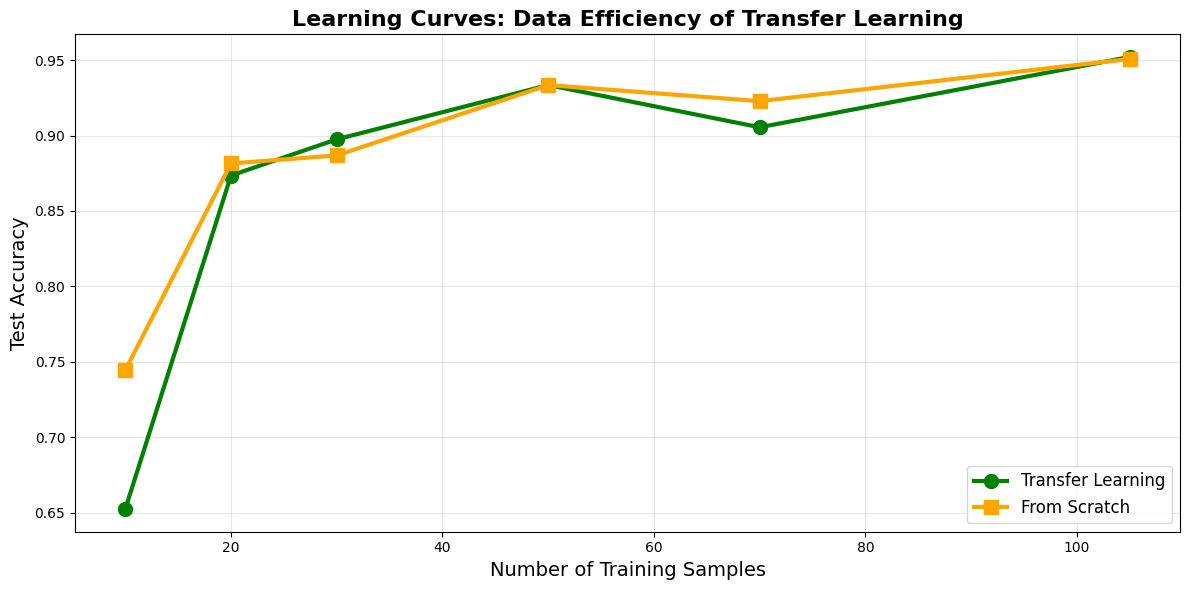


Key Observation:
Transfer learning achieves better performance with less training data!
This demonstrates the data efficiency advantage of transfer learning.


In [8]:
# Test with varying amounts of training data
train_sizes = [10, 20, 30, 50, 70, 105]  # Different numbers of training samples
transfer_scores = []
scratch_scores = []

print("Training with different data sizes...")
for size in train_sizes:
    # Ensure we have enough samples
    if size > len(X_target_train):
        continue
    
    # Sample training data
    indices = np.random.choice(len(X_target_train), size, replace=False)
    X_train_sample = X_target_train[indices]
    y_train_sample = y_target_train[indices]
    
    # Transfer Learning
    X_train_sample_scaled = scaler_source.transform(X_train_sample)
    X_train_sample_transfer = pca_pretrained.transform(X_train_sample_scaled)
    clf_temp_transfer = LogisticRegression(max_iter=1000, random_state=42)
    clf_temp_transfer.fit(X_train_sample_transfer, y_train_sample)
    score_transfer = clf_temp_transfer.score(X_target_test_transfer, y_target_test)
    transfer_scores.append(score_transfer)
    
    # From Scratch
    scaler_temp = StandardScaler()
    X_train_sample_scaled_scratch = scaler_temp.fit_transform(X_train_sample)
    X_test_sample_scaled_scratch = scaler_temp.transform(X_target_test)
    
    pca_temp = PCA(n_components=min(n_components, size - 1), random_state=42)
    X_train_sample_scratch = pca_temp.fit_transform(X_train_sample_scaled_scratch)
    X_test_sample_scratch = pca_temp.transform(X_test_sample_scaled_scratch)
    
    clf_temp_scratch = LogisticRegression(max_iter=1000, random_state=42)
    clf_temp_scratch.fit(X_train_sample_scratch, y_train_sample)
    score_scratch = clf_temp_scratch.score(X_test_sample_scratch, y_target_test)
    scratch_scores.append(score_scratch)
    
    print(f"Size {size:3d}: Transfer={score_transfer:.4f}, Scratch={score_scratch:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 6))

plt.plot(train_sizes[:len(transfer_scores)], transfer_scores, marker='o', 
         linewidth=3, markersize=10, label='Transfer Learning', color='green')
plt.plot(train_sizes[:len(scratch_scores)], scratch_scores, marker='s', 
         linewidth=3, markersize=10, label='From Scratch', color='orange')

plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.title('Learning Curves: Data Efficiency of Transfer Learning', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Observation:")
print("Transfer learning achieves better performance with less training data!")
print("This demonstrates the data efficiency advantage of transfer learning.")

### Step 8: Visualize Feature Space Comparison

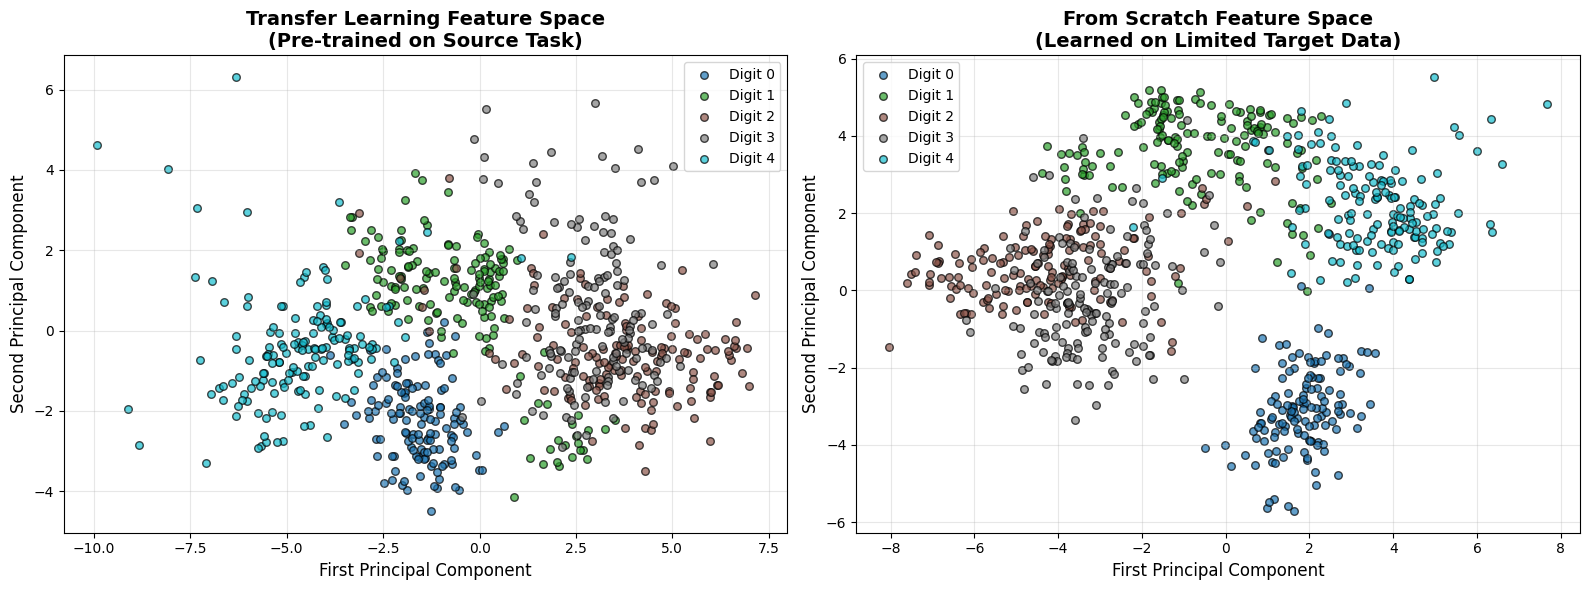


Observation:
The transfer learning feature space shows better class separation,
which explains its superior classification performance!


In [9]:
# Compare feature spaces learned by both methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Transfer Learning feature space
colors_target = plt.cm.tab10(np.linspace(0, 1, 5))
for digit in range(5):
    mask = y_target_test == digit
    ax1.scatter(X_target_test_transfer[mask, 0], X_target_test_transfer[mask, 1],
               c=[colors_target[digit]], label=f'Digit {digit}', alpha=0.7, s=30, edgecolor='black')

ax1.set_xlabel('First Principal Component', fontsize=12)
ax1.set_ylabel('Second Principal Component', fontsize=12)
ax1.set_title('Transfer Learning Feature Space\n(Pre-trained on Source Task)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# From Scratch feature space
for digit in range(5):
    mask = y_target_test == digit
    ax2.scatter(X_target_test_scratch[mask, 0], X_target_test_scratch[mask, 1],
               c=[colors_target[digit]], label=f'Digit {digit}', alpha=0.7, s=30, edgecolor='black')

ax2.set_xlabel('First Principal Component', fontsize=12)
ax2.set_ylabel('Second Principal Component', fontsize=12)
ax2.set_title('From Scratch Feature Space\n(Learned on Limited Target Data)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation:")
print("The transfer learning feature space shows better class separation,")
print("which explains its superior classification performance!")

## Hands-On Activity: Experiment with Transfer Learning

Now it's your turn! Try modifying the code above to explore:

### Exercise 1: Different Feature Dimensions
Change the number of PCA components (`n_components`) and observe how it affects:
- Transfer learning performance
- From-scratch performance
- The performance gap between the two methods

**Hint**: Try values like 10, 20, 40, and 50.

### Exercise 2: Different Target Tasks
Instead of classifying digits 0-4, try:
- Digits 5-9 (higher digits)
- Only even digits (0, 2, 4, 6, 8)
- Binary classification (e.g., digits 0-4 vs 5-9)

**Question**: Does transfer learning still provide benefits for these tasks?

### Exercise 3: Vary Training Data Size
Experiment with different amounts of target training data:
- Very limited: 50 samples
- Moderate: 200 samples
- Abundant: 500 samples

**Question**: When does transfer learning provide the most benefit?

### Exercise 4: Different Source Tasks
Try learning the feature extractor on:
- Only odd digits (1, 3, 5, 7, 9)
- Only digits 5-9
- A random subset

**Question**: How does the source task affect transfer learning performance?

In [10]:
# Your code here for hands-on experiments!
# Feel free to copy and modify code from above

# Example starter code for Exercise 1:
# n_components_test = 20  # Try different values
# pca_test = PCA(n_components=n_components_test, random_state=42)
# ... rest of the code

print("Ready for your experiments!")

Ready for your experiments!


## Key Takeaways

After completing this lesson, you should understand:

1. **Transfer learning leverages pre-trained representations** to solve new tasks more efficiently than training from scratch. This is especially powerful when you have limited data or computational resources.

2. **Feature extraction uses frozen pre-trained features** and trains only new layers, making it fast and suitable for small datasets. This approach preserves the learned knowledge from the source task.

3. **Pre-trained models learn reusable features**: Our PCA example showed that features learned on all digits (0-9) effectively transfer to classifying a subset of digits (0-4), even with limited training data.

4. **Transfer learning provides data efficiency**: As demonstrated by our learning curves, transfer learning achieves better performance with fewer training samples. This is critical in real-world applications where labeled data is expensive or scarce.

5. **The quality of learned features matters**: Pre-trained features capture patterns that generalize better than features learned from limited data, leading to improved classification boundaries and better separation between classes.

6. **Source and target task similarity affects performance**: Transfer learning works best when the source and target tasks share common underlying patterns. The more related the tasks, the more effective the transfer.

7. **Implementation with sklearn is straightforward**: While deep learning frameworks are commonly used for transfer learning, the fundamental concepts can be demonstrated with classical machine learning techniques like PCA and logistic regression.

### When to Use Transfer Learning

Transfer learning is most beneficial when:
- Your target dataset is small (< 1000 samples)
- A pre-trained model exists for a related task
- You want faster training and development cycles
- Computational resources are limited
- The source and target domains share common low-level features

## Further Resources

To deepen your understanding of transfer learning, explore these resources:

### Academic Papers
- **[A Survey on Transfer Learning (2010)](https://ieeexplore.ieee.org/document/5288526)**: Seminal paper by Pan and Yang providing theoretical foundations and taxonomy of transfer learning approaches.
- **[How transferable are features in deep neural networks? (2014)](https://arxiv.org/abs/1411.1792)**: Yosinski et al. investigate feature transferability across layers and tasks.
- **[Domain Adaptation for Visual Recognition (2013)](https://papers.nips.cc/paper/2013/file/9fb7b048c96d44a0337f8e2a1e3b2e1e-Paper.pdf)**: Explores domain adaptation techniques for computer vision.

### Online Tutorials
- **[CS231n: Transfer Learning](https://cs231n.github.io/transfer-learning/)**: Stanford's excellent computer vision course notes explaining when and how to use transfer learning.
- **[TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning)**: Official tutorial for implementing transfer learning with TensorFlow and Keras.
- **[PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**: Comprehensive guide using PyTorch and pre-trained ResNet models.

### Books
- **[Deep Learning Book - Chapter 15](https://www.deeplearningbook.org/)**: Ian Goodfellow's comprehensive treatment of representation learning and transfer learning.
- **[Hands-On Transfer Learning with Python](https://www.packtpub.com/product/hands-on-transfer-learning-with-python/9781788831307)**: Practical guide to implementing transfer learning across different domains.

### Pre-trained Models
- **[Keras Applications](https://keras.io/api/applications/)**: Collection of pre-trained models including ResNet, VGG, Inception, MobileNet, EfficientNet.
- **[PyTorch Hub](https://pytorch.org/hub/)**: Repository of pre-trained models for computer vision, NLP, and more.
- **[TensorFlow Hub](https://tfhub.dev/)**: Library of trained machine learning models ready for transfer learning.

### Practical Applications
- **Medical Imaging**: [Transfer Learning for Medical Image Classification](https://arxiv.org/abs/1902.07208)
- **Natural Language Processing**: [BERT: Pre-training of Deep Bidirectional Transformers](https://arxiv.org/abs/1810.04805)
- **Computer Vision**: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

### Interactive Resources
- **[Google Colab Transfer Learning Examples](https://colab.research.google.com/)**: Free GPU-enabled notebooks for experimenting with transfer learning.
- **[Fast.ai Course](https://course.fast.ai/)**: Practical deep learning course with extensive coverage of transfer learning techniques.